<a href="https://colab.research.google.com/github/MariamMoawed/OCR_Passport_MRZ_Recognition/blob/main/OCR_PassportMRZ_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-contrib-python

In [ ]:
!pip install pytesseract

In [ ]:
!sudo apt install tesseract-ocr
!sudo apt install libtesseract-dev
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libtesseract-dev is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
from google.colab.patches import cv2_imshow # Import the cv2_imshow function
import cv2
from imutils.contours import sort_contours
import numpy as np
import pytesseract
import argparse
import imutils
import sys
import cv2

In [ ]:
 # construct the argument parser and parse the arguments
import argparse

# Simulate command-line arguments
sys.argv = ['script_name.py', '-i', '/content/Screenshot 2024-12-19 132053.png']

ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", required=True,
	help="path to input image to be OCR'd")
args = vars(ap.parse_args())

# Replace 'path/to/your/image.jpg' with the actual path to your image

In [ ]:
# dimensions
image = cv2.imread(args["image"])
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
(H, W) = gray.shape

In [ ]:
# initialize a rectangular and square structuring kernel
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 7))
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 21))


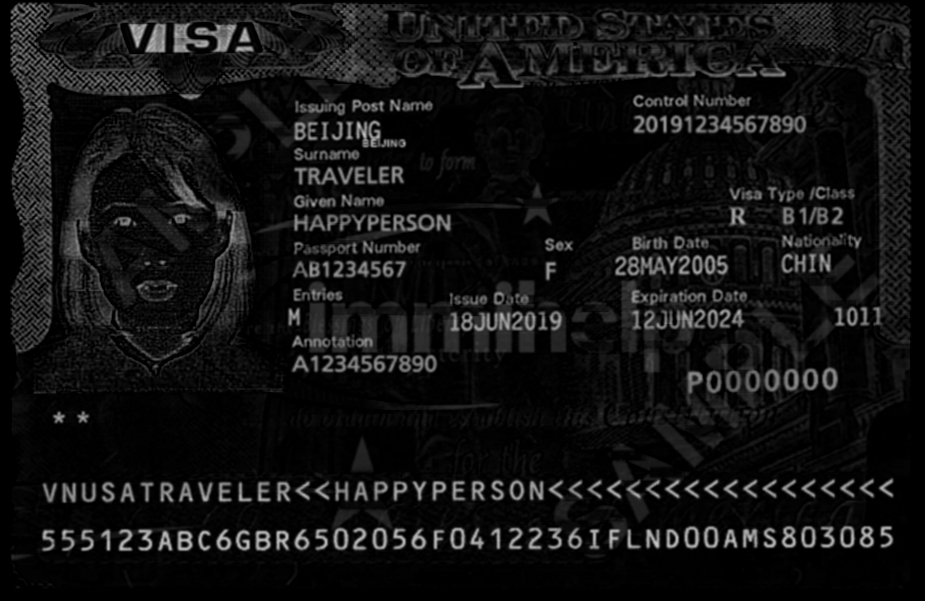

In [ ]:
#smooth the image using a 3x3 Gaussian blur and then apply a
# blackhat morpholigical operator to find dark regions on a light
# background
gray = cv2.GaussianBlur(gray, (3, 3), 0)
blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKernel)
cv2_imshow(blackhat)

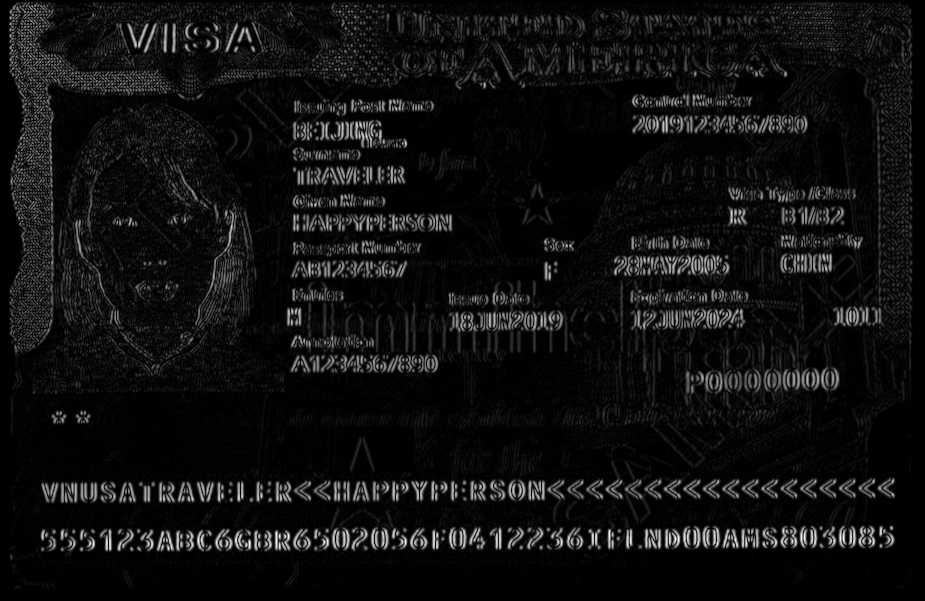

In [ ]:
# compute the Scharr gradient of the blackhat image and scale the
# result into the range [0, 255]
grad = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
grad = np.absolute(grad)
(minVal, maxVal) = (np.min(grad), np.max(grad))
grad = (grad - minVal) / (maxVal - minVal)
grad = (grad * 255).astype("uint8")
cv2_imshow( grad)

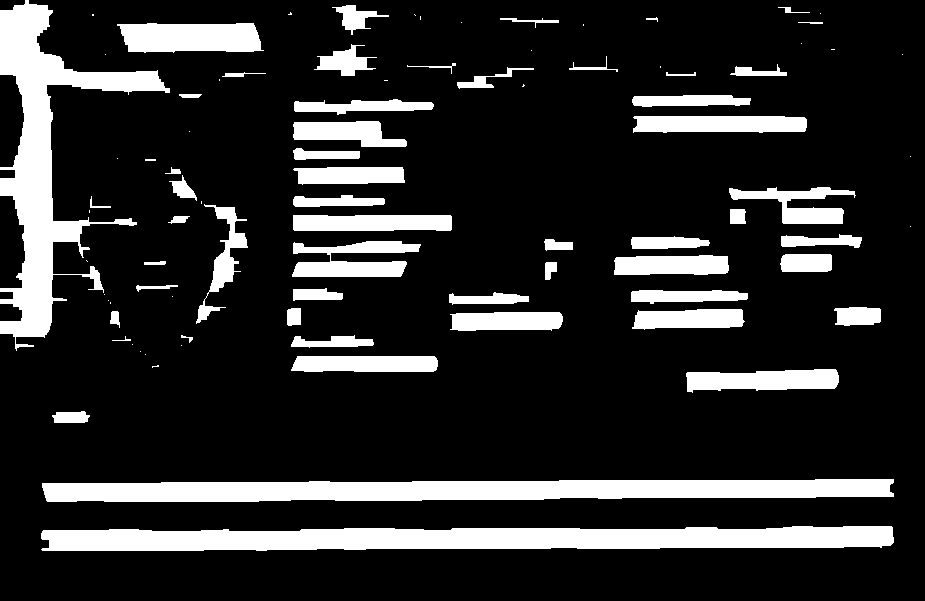

In [ ]:
# apply a closing operation using the rectangular kernel to close
# gaps in between letters -- then apply Otsu's thresholding method
grad = cv2.morphologyEx(grad, cv2.MORPH_CLOSE, rectKernel)
thresh = cv2.threshold(grad, 0, 255,
	cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
cv2_imshow(thresh)

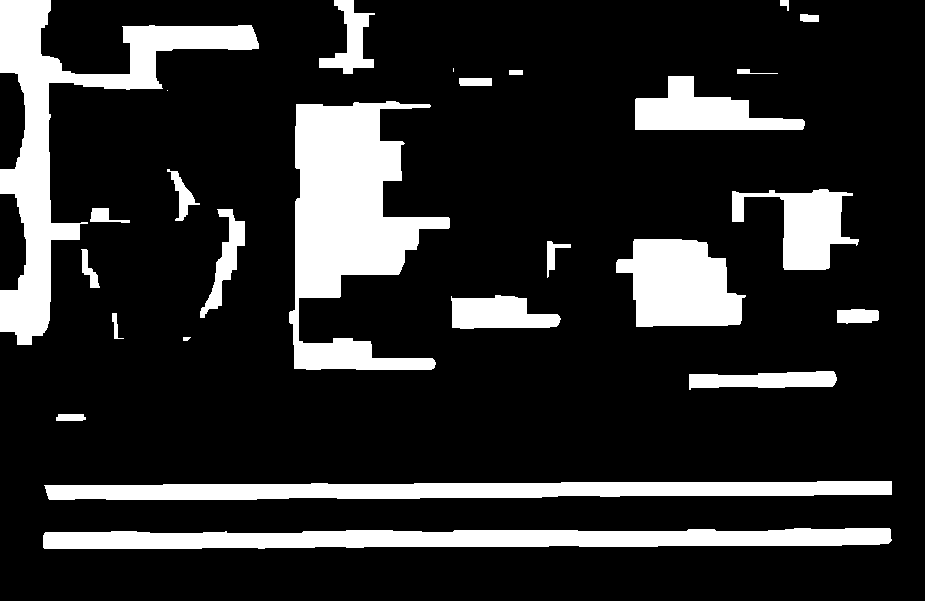

In [ ]:
# perform another closing operation, this time using the square
# kernel to close gaps between lines of the MRZ, then perform a
# series of erosions to break apart connected components
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel)
thresh = cv2.erode(thresh, None, iterations=2)
cv2_imshow(thresh)

In [ ]:
# find contours in the thresholded image and sort them from bottom
# to top (since the MRZ will always be at the bottom of the passport)
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sort_contours(cnts, method="bottom-to-top")[0]
# initialize the bounding box associated with the MRZ
mrzBox = None

In [ ]:
# loop over the contours
for c in cnts:
	# compute the bounding box of the contour and then derive the
	# how much of the image the bounding box occupies in terms of
	# both width and height
	(x, y, w, h) = cv2.boundingRect(c)
	percentWidth = w / float(W)
	percentHeight = h / float(H)
	# if the bounding box occupies > 80% width and > 4% height of the
	# image, then assume we have found the MRZ
	if percentWidth > 0.8 and percentHeight > 0.04:
		mrzBox = (x, y, w, h)
		break

[INFO] MRZ could not be found


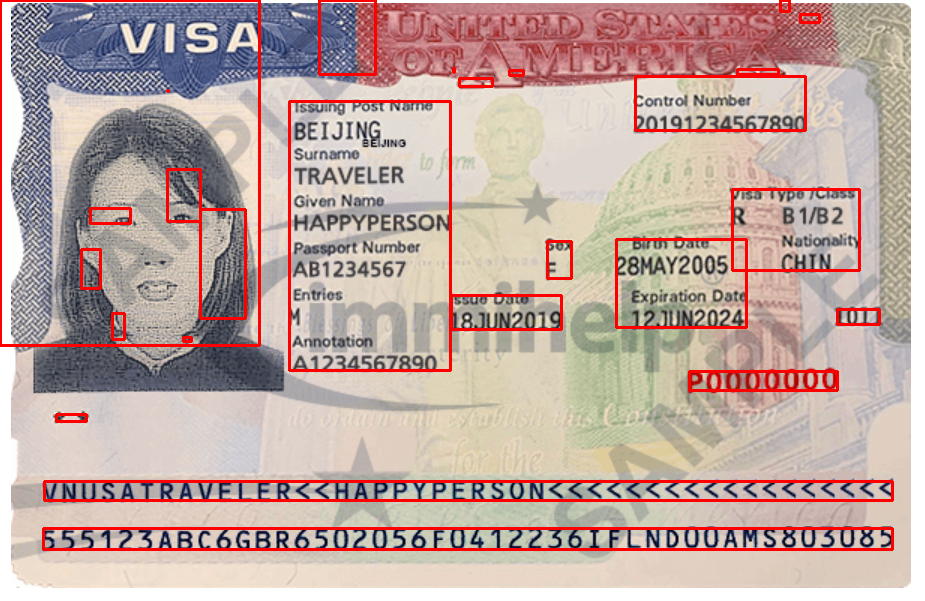

SystemExit: 

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
# if the MRZ was not found, display the image and highlight potential regions
if mrzBox is None:
    print("[INFO] MRZ could not be found")
    # Draw bounding boxes of all contours to visualize potential MRZ regions
    for c in cnts:
        (x, y, w, h) = cv2.boundingRect(c)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)
    cv2_imshow(image)
    # You can add further error handling or user interaction here
    # instead of directly exiting
    sys.exit() # Or raise an exception instead of exiting

# pad the bounding box since we applied erosions and now need to
# re-grow it
(x, y, w, h) = mrzBox
pX = int((x + w) * 0.03)
pY = int((y + h) * 0.03)
(x, y) = (x - pX, y - pY)
(w, h) = (w + (pX * 2), h + (pY * 2))
# extract the padded MRZ from the image
mrz = image[y:y + h, x:x + w]

In [ ]:
# OCR the MRZ region of interest using Tesseract, removing any
# occurrences of spaces
mrzText = pytesseract.image_to_string(mrz)
mrzText = mrzText.replace(" ", "")
print(mrzText)


In [ ]:
# show the MRZ image
cv2_imshow(mrz)
cv2.waitKey(0)